We will work with the California housing dataset and perform a linear regression to predict apartment prices based on the median income in the block. We will start from the simple linear regression and gradually finish with Stochastic Gradient Descent

### Import dependencies and libraries

In [1]:
import torch
import torch.nn as nn
from ignite.metrics.regression.r2_score import R2Score
from torch.nn import L1Loss
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.distributed as dist
import pandas as pd
from torch.optim.optimizer import Optimizer, required
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

/home/ryan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preparation and EDA

In [2]:
# read the csv file by providing the location of file after mounting drive
dataset = pd.read_csv('housing.csv')

# removed records with missing values
dataset = dataset.dropna()

# removing outliers
dataset = dataset[(dataset['median_income'] > 0) & (dataset['median_house_value'] < 500000)]

Plot for each feature of the dataset:


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

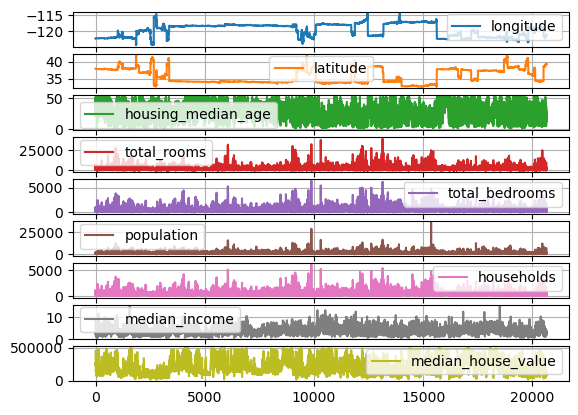

In [3]:
# plot each feature of the dataset on separate sub-plots
print("Plot for each feature of the dataset:")
dataset.plot(subplots = True, grid = True)

In [4]:
# Define columns for preprocessing
numeric_features = ['longitude', 'median_income', 'median_house_value']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Apply preprocessing
dataset = preprocessor.fit_transform(dataset)

# Convert preprocessed data to DataFrame
dataset = pd.DataFrame(dataset, columns=numeric_features)

In [5]:
# we have to predict the value of median house value so selected that column in Y
Y = dataset['median_house_value']

# the other remaining columns are selected in X
X = dataset.loc[:,'longitude':'median_income']

# split the dataset into training set and testing+validation set
x_train, x_test_val, y_train, y_test_val = train_test_split(X, Y, test_size=0.3, random_state=2003)

# split the testing+validation set into testing set and validation set
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=2003)

# convert the values of training set to the numpy array
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

# convert the values of validation set to the numpy array
x_val_np = x_val.to_numpy()
y_val_np = y_val.to_numpy()

# convert the values of testing set to the numpy array
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

### Optimizers

In [6]:
# NAG Optimizer
class NAG(Optimizer):
    def __init__(self, params, lr=required, momentum=0, weight_decay=0):
        defaults = dict(lr=lr, lr_old=lr, momentum=momentum, weight_decay=weight_decay)
        super(NAG, self).__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self):
        return True

    @property
    def supports_flat_params(self):
        return True

    def step(self, closure=None):
        """Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            lr = group["lr"]
            lr_old = group.get("lr_old", lr)
            lr_correct = lr / lr_old if lr_old > 0 else lr

            for p in group["params"]:
                if p.grad is None:
                    continue

                p_data_fp32 = p.data
                if p_data_fp32.dtype in {torch.float16, torch.bfloat16}:
                    p_data_fp32 = p_data_fp32.float()

                d_p = p.grad.data.float()
                param_state = self.state[p]
                if "momentum_buffer" not in param_state:
                    param_state["momentum_buffer"] = torch.zeros_like(d_p)
                else:
                    param_state["momentum_buffer"] = param_state["momentum_buffer"].to(
                        d_p
                    )

                buf = param_state["momentum_buffer"]

                if weight_decay != 0:
                    p_data_fp32.mul_(1 - lr * weight_decay)
                p_data_fp32.add_(buf, alpha=momentum * momentum * lr_correct)
                p_data_fp32.add_(d_p, alpha=-(1 + momentum) * lr)

                buf.mul_(momentum * lr_correct).add_(d_p, alpha=-lr)

                if p.data.dtype in {torch.float16, torch.bfloat16}:
                    p.data.copy_(p_data_fp32)

            group["lr_old"] = lr

        return loss

In [7]:
# ProxSG
class ProxSG(Optimizer):
    def __init__(self, params, lr=required, lambda_=required):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        if lambda_ is not required and lambda_ < 0.0:
            raise ValueError("Invalid lambda: {}".format(lambda_))

        defaults = dict(lr=lr, lambda_=lambda_)
        super(ProxSG, self).__init__(params, defaults)

    def calculate_d(self, x, grad_f, lambda_, lr):
        '''
            Calculate d for Omega(x) = ||x||_1
        '''
        trial_x = torch.zeros_like(x)
        pos_shrink = x - lr * grad_f - lr * \
            lambda_  # new x is larger than lr * lambda_
        neg_shrink = x - lr * grad_f + lr * \
            lambda_  # new x is less than -lr * lambda_
        pos_shrink_idx = (pos_shrink > 0)
        neg_shrink_idx = (neg_shrink < 0)
        trial_x[pos_shrink_idx] = pos_shrink[pos_shrink_idx]
        trial_x[neg_shrink_idx] = neg_shrink[neg_shrink_idx]
        d = trial_x - x

        return d

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad_f = p.grad.data

                if len(p.shape) > 1:  # weights
                    s = self.calculate_d(
                        p.data, grad_f, group['lambda_'], group['lr'])
                    p.data.add_(s, alpha=1)
                else:  # bias
                    p.data.add_(grad_f, alpha=-group['lr'])
        return loss

In [8]:
# SVRG Optimizer
class SVRG(Optimizer):
    r""" implement SVRG """ 

    def __init__(self, params, lr=required, freq =10):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr, freq=freq)
        self.counter = 0
        self.counter2 = 0
        self.flag = False
        super(SVRG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SVRG, self).__setstate__(state)
        # for group in self.param_groups:
        #     group.setdefault('m', )

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            freq = group['freq']
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                param_state = self.state[p]
                
                if 'large_batch' not in param_state:
                    buf = param_state['large_batch'] = torch.zeros_like(p.data)
                    buf.add_(d_p) #add first large, low variance batch
                    #need to add the second term in the step equation; the gradient for the original step!
                    buf2 = param_state['small_batch'] = torch.zeros_like(p.data)

                buf = param_state['large_batch']
                buf2 = param_state['small_batch']

                if self.counter == freq:
                    buf.data = d_p.clone() #copy new large batch. Begining of new inner loop
                    temp = torch.zeros_like(p.data)
                    buf2.data = temp.clone()
                    
                if self.counter2 == 1:
                    buf2.data.add_(d_p) #first small batch gradient for inner loop!

                #dont update parameters when computing large batch (low variance gradients)
                if self.counter != freq and self.flag != False:
                    p.data.add_((d_p - buf2 + buf), alpha=-group['lr'])

        self.flag = True #rough way of not updating the weights the FIRST time we calculate the large batch gradient
        
        if self.counter == freq:
            self.counter = 0
            self.counter2 = 0

        self.counter += 1    
        self.counter2 += 1

        return loss

In [9]:
class Prodigy(Optimizer):
    r"""
    Implements Adam with Prodigy step-sizes.
    Leave LR set to 1 unless you encounter instability.
   
    Arguments:
        params (iterable):
            Iterable of parameters to optimize or dicts defining parameter groups.
        lr (float):
            Learning rate adjustment parameter. Increases or decreases the Prodigy learning rate.
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        beta3 (float):
            coefficients for computing the Prodidy stepsize using running averages.
            If set to None, uses the value of square root of beta2 (default: None).
        eps (float):
            Term added to the denominator outside of the root operation to improve numerical stability. (default: 1e-8).
        weight_decay (float):
            Weight decay, i.e. a L2 penalty (default: 0).
        decouple (boolean):
            Use AdamW style decoupled weight decay
        use_bias_correction (boolean):
            Turn on Adam's bias correction. Off by default.
        safeguard_warmup (boolean):
            Remove lr from the denominator of D estimate to avoid issues during warm-up stage. Off by default.
        d0 (float):
            Initial D estimate for D-adaptation (default 1e-6). Rarely needs changing.
        d_coef (float):
            Coefficient in the expression for the estimate of d (default 1.0).
            Values such as 0.5 and 2.0 typically work as well. 
            Changing this parameter is the preferred way to tune the method.
        growth_rate (float):
            prevent the D estimate from growing faster than this multiplicative rate.
            Default is inf, for unrestricted. Values like 1.02 give a kind of learning
            rate warmup effect.
        fsdp_in_use (bool):
            If you're using sharded parameters, this should be set to True. The optimizer
            will attempt to auto-detect this, but if you're using an implementation other
            than PyTorch's builtin version, the auto-detection won't work.
    """
    def __init__(self, params, lr=1.0,
                 betas=(0.9, 0.999), beta3=None,
                 eps=1e-8, weight_decay=0, decouple=True, 
                 use_bias_correction=False, safeguard_warmup=False,
                 d0=1e-6, d_coef=1.0, growth_rate=float('inf'),
                 fsdp_in_use=False):
        if not 0.0 < d0:
            raise ValueError("Invalid d0 value: {}".format(d0))
        if not 0.0 < lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 < eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        if decouple and weight_decay > 0:
            print(f"Using decoupled weight decay")

       
        defaults = dict(lr=lr, betas=betas, beta3=beta3,
                        eps=eps, weight_decay=weight_decay,
                        d=d0, d0=d0, d_max=d0,
                        d_numerator=0.0, d_coef=d_coef,
                        k=0, growth_rate=growth_rate,
                        use_bias_correction=use_bias_correction,
                        decouple=decouple, safeguard_warmup=safeguard_warmup,
                        fsdp_in_use=fsdp_in_use)
        self.d0 = d0
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self):
        return False

    @property
    def supports_flat_params(self):
        return True

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        d_denom = 0.0

        group = self.param_groups[0]
        use_bias_correction = group['use_bias_correction']
        beta1, beta2 = group['betas']
        beta3 = group['beta3']
        if beta3 is None:
            beta3 = math.sqrt(beta2)
        k = group['k']

        d = group['d']
        d_max = group['d_max']
        d_coef = group['d_coef']
        lr = max(group['lr'] for group in self.param_groups)

        if use_bias_correction:
            bias_correction = ((1 - beta2**(k+1))**0.5) / (1 - beta1**(k+1))
        else:
            bias_correction = 1

        dlr = d*lr*bias_correction
       
        growth_rate = group['growth_rate']
        decouple = group['decouple']
        fsdp_in_use = group['fsdp_in_use']

        d_numerator = group['d_numerator']
        d_numerator *= beta3

        for group in self.param_groups:
            decay = group['weight_decay']
            k = group['k']
            eps = group['eps']
            group_lr = group['lr']
            d0 = group['d0']
            safeguard_warmup = group['safeguard_warmup']

            if group_lr not in [lr, 0.0]:
                raise RuntimeError(f"Setting different lr values in different parameter groups is only supported for values of 0")

            for p in group['params']:
                if p.grad is None:
                    continue
                if hasattr(p, "_fsdp_flattened"):
                    fsdp_in_use = True
               
                grad = p.grad.data
               
                # Apply weight decay (coupled variant)
                if decay != 0 and not decouple:
                    grad.add_(p.data, alpha=decay)

                state = self.state[p]

                # State initialization
                if 'step' not in state:
                    state['step'] = 0
                    state['s'] = torch.zeros_like(p.data).detach()
                    state['p0'] = p.detach().clone()
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data).detach()
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data).detach()

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
               
                s = state['s']
                p0 = state['p0']

                if group_lr > 0.0:
                    # we use d / d0 instead of just d to avoid getting values that are too small
                    d_numerator += (d / d0) * dlr * torch.dot(grad.flatten(), (p0.data - p.data).flatten()).item()

                    # Adam EMA updates
                    exp_avg.mul_(beta1).add_(grad, alpha=d * (1-beta1))
                    exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=d * d * (1-beta2))

                    if safeguard_warmup:
                        s.mul_(beta3).add_(grad, alpha=((d / d0) * d))
                    else:
                        s.mul_(beta3).add_(grad, alpha=((d / d0) * dlr))
                    d_denom += s.abs().sum().item()

            ######

        d_hat = d

        # if we have not done any progres, return
        # if we have any gradients available, will have d_denom > 0 (unless \|g\|=0)
        if d_denom == 0:
            return loss
       
        if lr > 0.0:
            if fsdp_in_use:
                dist_tensor = torch.zeros(2).cuda()
                dist_tensor[0] = d_numerator
                dist_tensor[1] = d_denom
                dist.all_reduce(dist_tensor, op=dist.ReduceOp.SUM)
                global_d_numerator = dist_tensor[0]
                global_d_denom = dist_tensor[1]
            else:
                global_d_numerator = d_numerator
                global_d_denom = d_denom

            d_hat = d_coef * global_d_numerator / global_d_denom
            if d == group['d0']:
                d = max(d, d_hat)
            d_max = max(d_max, d_hat)
            d = min(d_max, d * growth_rate)

        for group in self.param_groups:
            group['d_numerator'] = global_d_numerator
            group['d_denom'] = global_d_denom
            group['d'] = d
            group['d_max'] = d_max
            group['d_hat'] = d_hat

            decay = group['weight_decay']
            k = group['k']
            eps = group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                state = self.state[p]

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                state['step'] += 1

                denom = exp_avg_sq.sqrt().add_(d * eps)

                # Apply weight decay (decoupled variant)
                if decay != 0 and decouple:
                    p.data.add_(p.data, alpha=-decay * dlr)


                ### Take step
                p.data.addcdiv_(exp_avg, denom, value=-dlr)

            group['k'] = k + 1

        return loss

In [10]:
class Ranger(Optimizer):

    def __init__(self, params, lr=1e-3,                       # lr
                 alpha=0.5, k=6, N_sma_threshhold=5,           # Ranger options
                 betas=(.95, 0.999), eps=1e-5, weight_decay=0,  # Adam options
                 # Gradient centralization on or off, applied to conv layers only or conv + fc layers
                 use_gc=True, gc_conv_only=False
                 ):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas,
                        N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.use_gc = use_gc

        # level of gradient centralization
        self.gc_gradient_threshold = 3 if gc_conv_only else 1

    def __setstate__(self, state):
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(state) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                if grad.dim() > self.gc_gradient_threshold:
                    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay']
                                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(exp_avg, denom, value=-step_size*
                                         group['lr'])

                else:
                    p_data_fp32.add_(exp_avg, alpha=-step_size * group['lr'])

                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

### Linear Regression Model

In [11]:
# Define model named CnnRegressor
class CnnRegressor(torch.nn.Module):
  # defined the initialization method
  def __init__(self, batch_size, inputs, outputs):
    # initialization of the superclass
    super(CnnRegressor, self).__init__()
    # store the parameters
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    # define the input layer
    self.input_layer = Conv1d(inputs, batch_size, 1, stride = 1)
   
    # define max pooling layer
    self.max_pooling_layer = MaxPool1d(1)

    # define other convolutional layers
    self.conv_layer1 = Conv1d(batch_size, 128, 1, stride = 3)
    self.conv_layer2 = Conv1d(128, 256, 1, stride = 3)
    self.conv_layer3 = Conv1d(256, 512, 1, stride = 3)

    # define the flatten layer
    self.flatten_layer = Flatten()

    # define the linear layer
    self.linear_layer = Linear(512, 128)

    # define the output layer
    self.output_layer = Linear(128, outputs)

  # define the method to feed the inputs to the model
  def feed(self, input):
    # input is reshaped to the 1D array and fed into the input layer
    input = input.reshape((self.batch_size, self.inputs, 1))

    # ReLU is applied on the output of input layer
    output = relu(self.input_layer(input))

    # max pooling is applied and then Convolutions are done with ReLU
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer1(output))

    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer2(output))

    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer3(output))

    # flatten layer is applied
    output = self.flatten_layer(output)

    # linear layer and ReLu is applied
    output = relu(self.linear_layer(output))

    # finally, output layer is applied
    output = self.output_layer(output)
    return output

In [12]:
# define the method for calculating average L1 Loss and R2 Score of given model
def model_loss(model, dataset, train = False, optimizer = None):
  # first calculated for the batches and at the end get the average
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0

  for input, output in iter(dataset):
    # get predictions of the model for training set
    predictions = model.feed(input)

    # calculate loss of the model
    loss = performance(predictions, output)

    # compute the R2 score
    score_metric.update([predictions, output])
    score = score_metric.compute()

    if(train):
      # clear the errors
      optimizer.zero_grad()

      # compute the gradients for optimizer
      loss.backward()

      # use optimizer in order to update parameters
      # of the model based on gradients
      optimizer.step()

    # store the loss and update values
    avg_loss += loss.item()
    avg_score += score
    count += 1

  return avg_loss/count, avg_score/count

### Train Model

In [ ]:
# Plot correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(data=dataset, x='median_income', y='median_house_value')
plt.title('Correlation Between Price and Income')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.grid(True)
plt.show()

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# define the batch size  
batch_size = 100
epochs = 250

# to process with GPU, training set is converted into torch variable
inputs = torch.from_numpy(x_train_np).to(device).float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).to(device).float()

# create the DataLoader instance to work with batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)

cuda


In [54]:
optimizers = {
    "SGD": optim.SGD,
    "RMSProp": optim.RMSprop,
    "Adam": optim.Adam,
    "AdaDelta": optim.Adadelta,
    "Ranger": Ranger, 
    "Prodigy": Prodigy,
    "NAG": NAG, 
    "ProxSG": ProxSG, 
    "SVRG": SVRG
}

optimizer_colors = {
   "SGD": 'blue',
    "RMSProp": 'green',
    "Adam": 'darkorange',
    "AdaDelta": 'red',
    "Ranger": 'purple', 
    "Prodigy": 'brown',
    "NAG": 'pink', 
    "ProxSG": 'gray', 
    "SVRG": 'olive'
}

Training with SGD optimizer...
Epoch 1:
	Loss = 0.8200693218147054	R^2 Score = -0.014515750200403323
	Validation Loss = 0.807089719279059	Validation R^2 Score = -0.004771266716491234
Epoch 2:
	Loss = 0.810683432747336	R^2 Score = -0.0007158691929946485
	Validation Loss = 0.7984248296967869	Validation R^2 Score = 0.003368837605431205
Epoch 3:
	Loss = 0.803712702849332	R^2 Score = 0.004523295962185638
	Validation Loss = 0.790973005623653	Validation R^2 Score = 0.0038299227375230625
Epoch 4:
	Loss = 0.7981126268996912	R^2 Score = 0.006659051706793063
	Validation Loss = 0.7881986704365961	Validation R^2 Score = 0.005558869217554946
Epoch 5:
	Loss = 0.7935284472563687	R^2 Score = 0.00723848739552667
	Validation Loss = 0.7831267241773934	Validation R^2 Score = 0.005633826964907004
Epoch 6:
	Loss = 0.790114779244451	R^2 Score = 0.008174610852971899
	Validation Loss = 0.7811075818949732	Validation R^2 Score = 0.008243800618519868
Epoch 7:
	Loss = 0.7874393616529072	R^2 Score = 0.00725077899051

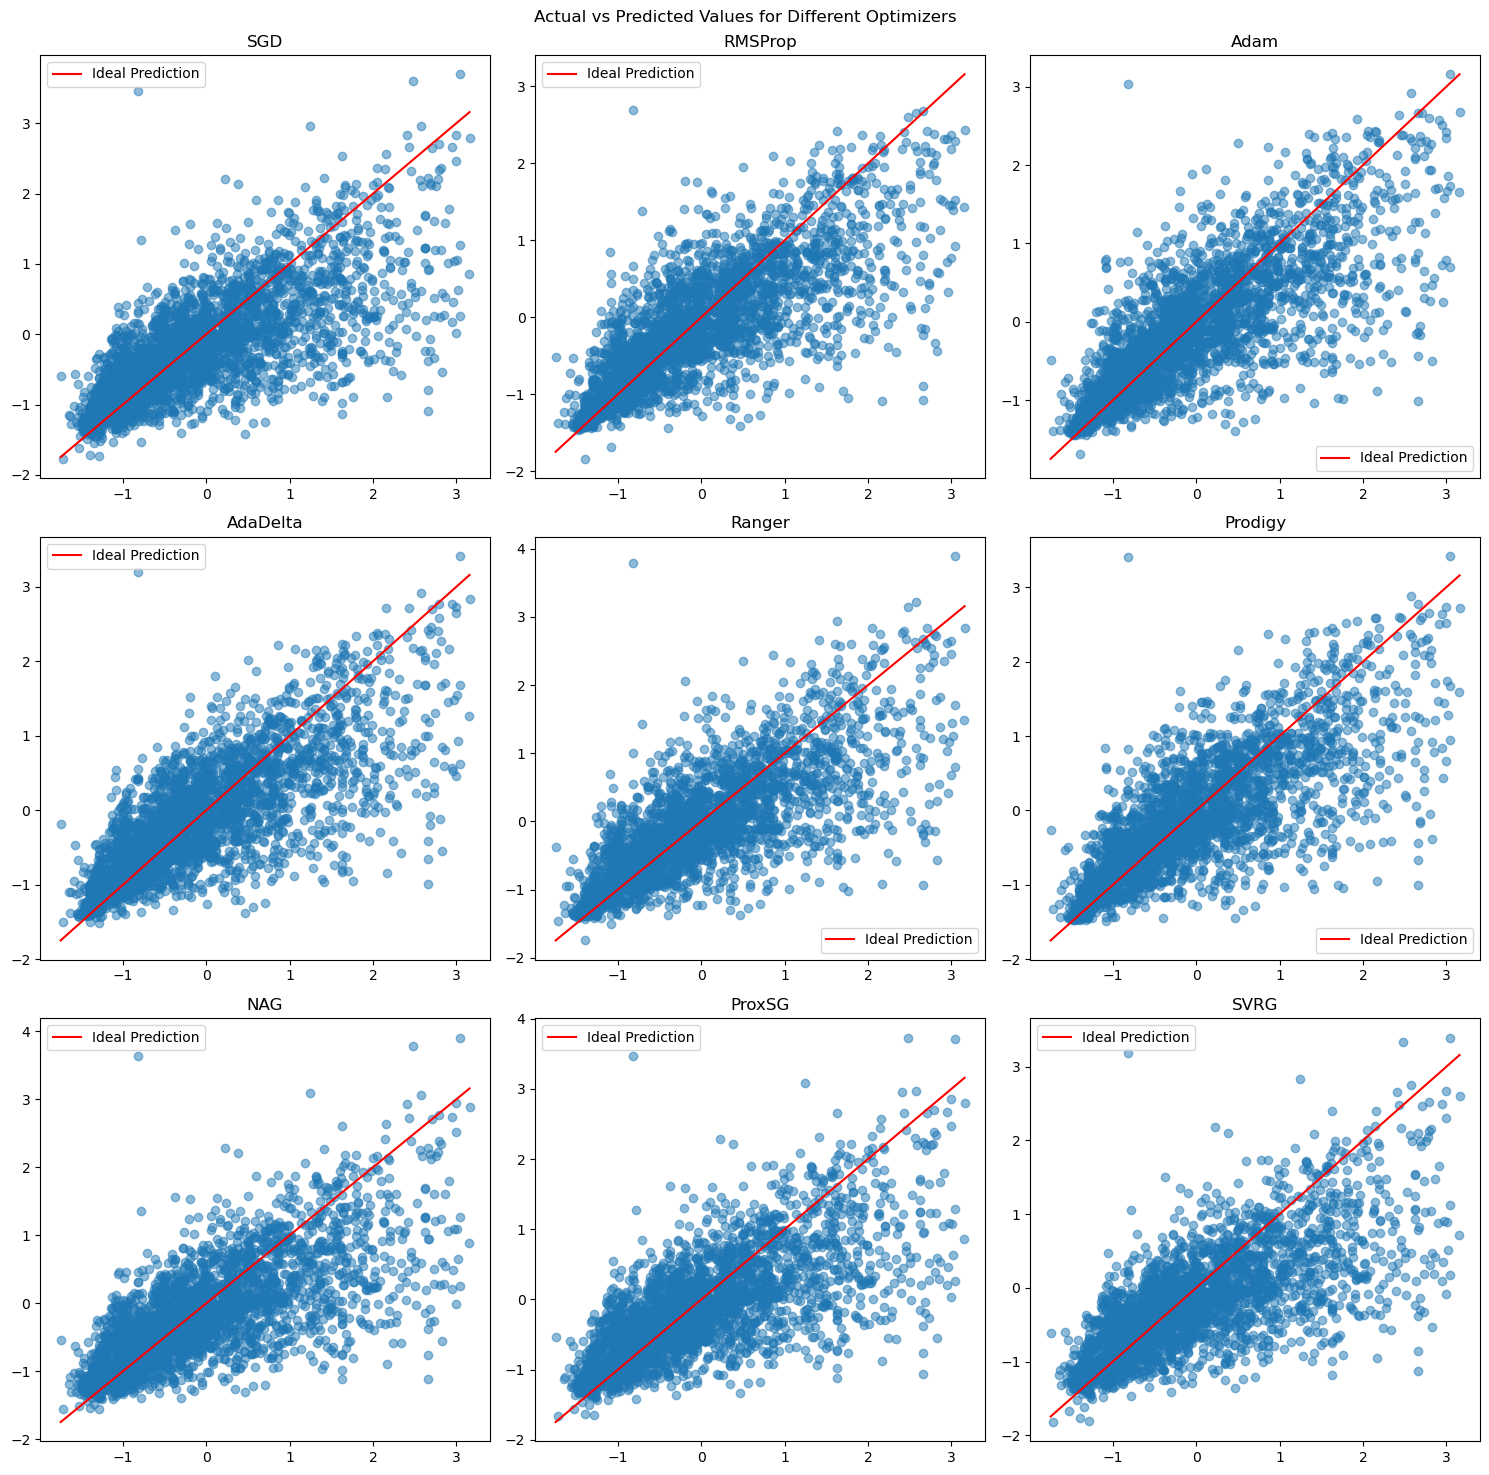

In [55]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()

train_losses = {}
test_losses = {}
accuracies = {}

for i, (opt_name, optimizer_class) in enumerate(optimizers.items()):
   print(f"Training with {opt_name} optimizer...")
   model = CnnRegressor(batch_size, X.shape[1], 1)
   model.to(device)

   if opt_name == 'AdaDelta' or opt_name == 'Prodigy':
      optimizer = optimizer_class(model.parameters(), lr = 1e-2)
   elif opt_name == 'ProxSG':
      optimizer = optimizer_class(model.parameters(), lr = 1e-3, lambda_=0.0001)
   else:
      optimizer = optimizer_class(model.parameters(), lr = 1e-3)

   best_accuracy = 0.0
   train_losses[opt_name] = []
   test_losses[opt_name] = []

   # Train the model
   for epoch in range(epochs):
      model.train()
      optimizer.zero_grad()
      # model is cycled through the batches
      avg_loss, avg_r2_score = model_loss(model, loader, train = True, optimizer = optimizer)

      train_losses[opt_name].append(avg_loss)

      model.eval()
      # Evaluate the model on the validation set
      inputs_val = torch.from_numpy(x_val_np).to(device).float()
      outputs_val = torch.from_numpy(y_val_np.reshape(y_val_np.shape[0],1)).to(device).float()

      # create the DataLoader instance to work with batches
      tensor_val = TensorDataset(inputs_val, outputs_val)
      loader_val = DataLoader(tensor_val, batch_size, shuffle = True, drop_last = True)

      # output of the performance of the model
      avg_loss_val, avg_r2_score_val = model_loss(model, loader_val)
      print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\tR^2 Score = " + str(avg_r2_score) + "\n\tValidation Loss = " + str(avg_loss_val) + "\tValidation R^2 Score = " + str(avg_r2_score_val))

      test_losses[opt_name] = avg_loss_val
      
      # Save the model if it has the best accuracy so far on the validation set
      if avg_r2_score_val > best_accuracy:
         best_accuracy = avg_r2_score_val
         torch.save(model.state_dict(), f"best_{opt_name}.pkl")

   # Calculate the accuracy
   model.eval()
   test_inputs = torch.from_numpy(x_test_np).to(device).float()
   test_outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).to(device).float()

   # create the DataLoader instance to work with batches
   test_tensor = TensorDataset(test_inputs, test_outputs)
   test_loader = DataLoader(test_tensor, batch_size, shuffle = True, drop_last = True)

   # Plot the regression line for the current optimizer
   with torch.no_grad():
      predictions = []
      actuals = []
      for inputs, targets, in test_loader:
         output = model.feed(inputs)
         predictions.append(output.cpu().detach().numpy())
         actuals.append(targets.cpu().detach().numpy())

   predictions = np.concatenate(predictions, axis=0)
   actuals = np.concatenate(actuals, axis=0)
   axs[i].scatter(actuals, predictions, alpha=0.5)
   axs[i].plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], color='red', label='Ideal Prediction')
   axs[i].set_title(opt_name)
   axs[i].legend()

   # output of the performance of the model
   avg_loss, avg_r2_score = model_loss(model, loader)
   accuracies[opt_name] = avg_r2_score
   print("The model's L1 loss is: " + str(avg_loss))
   print("The model's R^2 score is: " + str(avg_r2_score))

# Add plot details
plt.suptitle('Actual vs Predicted Values for Different Optimizers')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

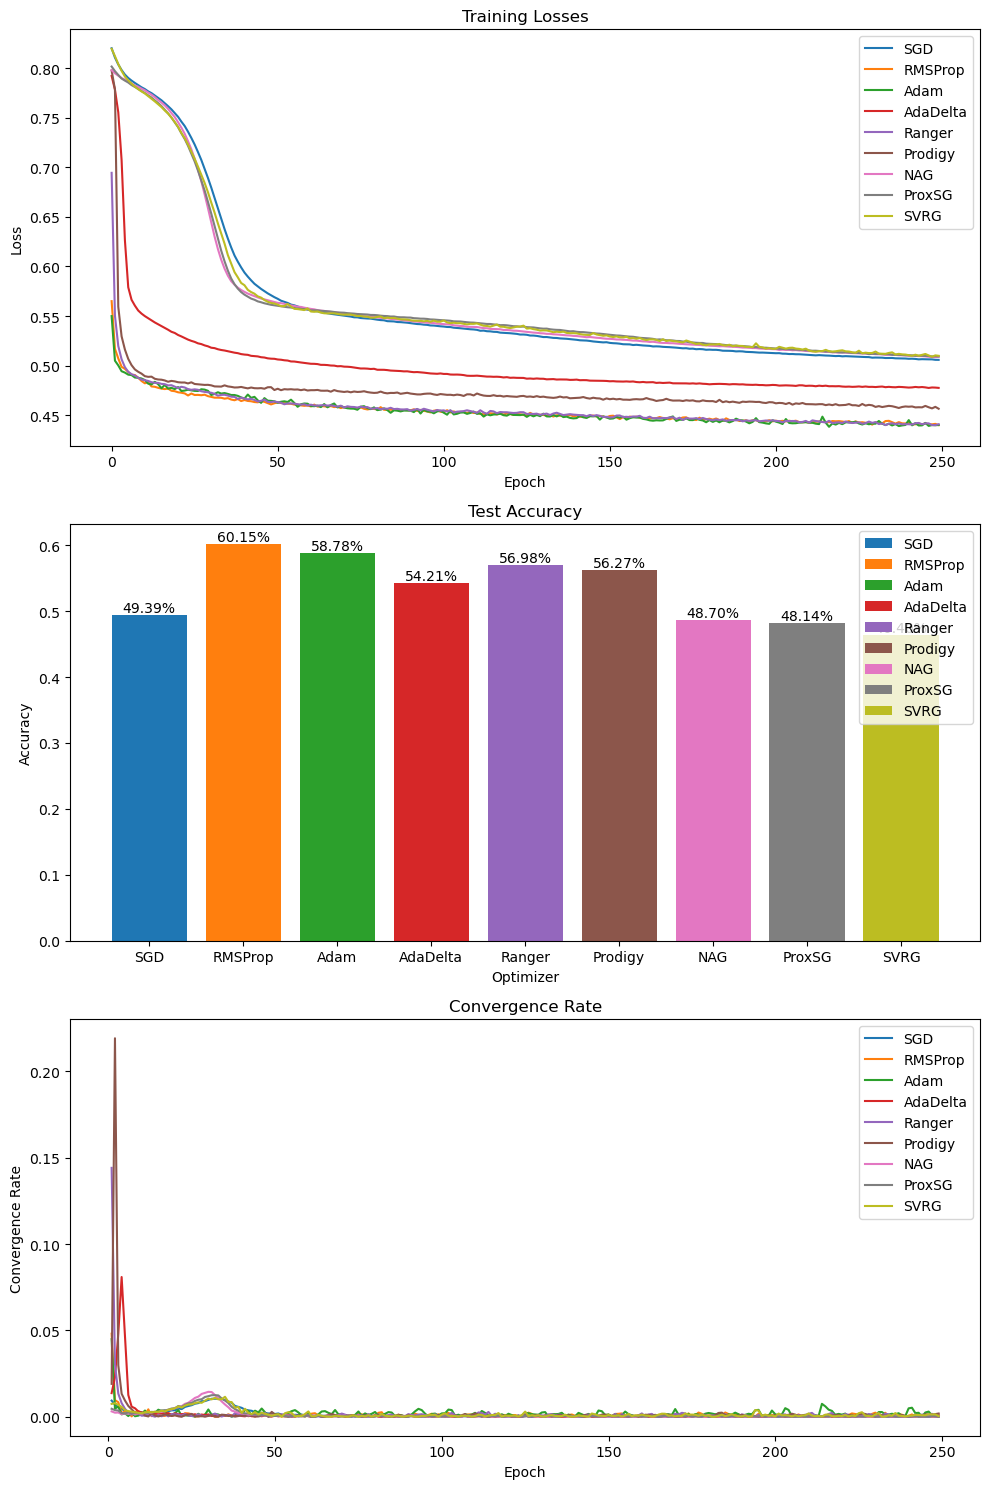

In [56]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot losses
for opt_name in optimizers:
    losses = train_losses[opt_name]
    axs[0].plot(losses, label=f'{opt_name}')
axs[0].set_title('Training Losses')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot accuracies
for opt_name in optimizers:
    accuracy = accuracies[opt_name]
    bar = axs[1].bar(opt_name, accuracy, label=f'{opt_name}')
    axs[1].text(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height(), f'{accuracies[opt_name]*100:.2f}%', ha='center', va='bottom')
axs[1].set_title('Test Accuracy')
axs[1].set_xlabel('Optimizer')
axs[1].set_ylabel('Accuracy')
axs[1].legend() 

# Plot convergence rates
for opt_name in optimizers:
    losses = train_losses[opt_name]
    convergence_rates = [abs(losses[i] - losses[i-1]) for i in range(1, len(losses))]
    axs[2].plot(range(1, len(losses)), convergence_rates, label=f'{opt_name}')
axs[2].set_title('Convergence Rate')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Convergence Rate')
axs[2].legend()

plt.tight_layout()
plt.show()